<a href="https://colab.research.google.com/github/CyberJuan55/GenderPredict/blob/master/GenderPredict_RedNeuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, label_binarize
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import stats
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from sklearn.compose import make_column_transformer



urlTrain  = 'https://raw.githubusercontent.com/CyberJuan55/GenderPredict/master/Dataset/SpotifyFeatures.csv_train.csv'
urlFull = 'https://github.com/CyberJuan55/GenderPredict/blob/master/Dataset/SpotifyFeatures.csv'
urlNuevoDataSet = 'https://github.com/CyberJuan55/GenderPredict/blob/master/Dataset/genres_v2.csv'



df_train_original = pd.read_csv(urlTrain)

df_train = df_train_original.copy()

In [12]:
# Funcion para el preprocesamiento de datos
def preprocesado(df,out=False):

    df.drop_duplicates()
    df.dropna(axis=0, inplace=True)


    df = df.loc[:,['genre','popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness',
       'speechiness', 'tempo','valence']] 

    df['genre']= df['genre'].replace(["Children’s Music"],"Children's Music")

    #indexNamesChildren = df[ df['genre'] == "Children's Music" ].index
    #df.drop(indexNamesChildren , inplace=True)

    indexNamesAcapella = df[ df['genre'] == "A Capella"].index
    df.drop(indexNamesAcapella , inplace=True)


#-------------------------------------------------------------------------------

    

    if out == True:
        labelencoder = LabelEncoder()
        df["genre"] = labelencoder.fit_transform(df["genre"])

        df_train_genres = df
        generos=list(df_train['genre'].unique())

        b = []
        for i in generos:
            df=df_train_genres[df_train_genres["genre"]==i].drop(columns=["genre","mode","key"])
     
            z = np.abs(stats.zscore(df))
            a=np.where(z > 3)
            outliers=list(set(list(a[0])))
            ñ = [df.iloc[x,:].name for x in outliers]
            b = ñ + b
        df_train_genres.drop(b, axis = 0, inplace = True)

        df = df_train_genres
#-------------------------------------------------------------------------------
    y = df['genre']    
    X = df.drop(columns=['genre'])
#-------------------------------------------------------------------------------   
    return X,y

In [13]:
df_train,y = preprocesado(df_train,out=False)

In [20]:
list(y.unique())

['Opera',
 'Reggaeton',
 'Indie',
 'Soundtrack',
 'Hip-Hop',
 'World',
 'Classical',
 'Electronic',
 'Reggae',
 'Alternative',
 'Ska',
 'Movie',
 'Jazz',
 'Rock',
 'Country',
 'R&B',
 'Rap',
 'Folk',
 'Anime',
 "Children's Music",
 'Pop',
 'Dance',
 'Blues',
 'Comedy',
 'Soul']

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
X_train_full, X_valid_full, y_train_full, y_valid_full = train_test_split(df_train, y, 
                                                                train_size=0.7, test_size=0.3,
                                                                random_state=42)

In [15]:
features_num=list(df_train)
preprocessor_X = make_column_transformer(
    (StandardScaler(), features_num),
)


In [16]:
features_cat = 'genre'
preprocessor_y = make_column_transformer(
    (OneHotEncoder(), features_cat),
)

In [17]:
X_train = preprocessor_X.fit_transform(X_train_full)
X_valid = preprocessor_X.transform(X_valid_full)


In [18]:
y_train_df = pd.DataFrame(y_train_full)
y_valid_df = pd.DataFrame(y_valid_full)

In [20]:
onehot = OneHotEncoder(sparse=False)
y_train  = onehot.fit_transform(y_train_df)
y_valid = onehot.transform(y_valid_df)

In [21]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
input_shape = [X_train.shape[1]]

In [23]:
input_shape

[11]

In [18]:
y_train.shape

(130258, 25)

In [24]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(25,activation='softmax')
])

In [29]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)

Minimum Validation Loss: 1.6918


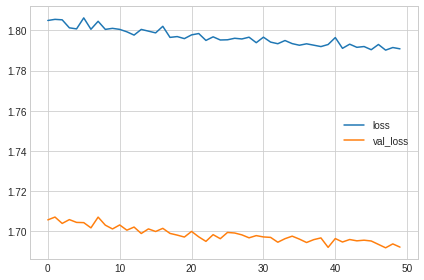

In [31]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')



history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))